<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gaussian-Features" data-toc-modified-id="Gaussian-Features-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gaussian Features</a></span></li><li><span><a href="#General-Linear-Regression" data-toc-modified-id="General-Linear-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>General Linear Regression</a></span></li><li><span><a href="#Non-linear-Regression" data-toc-modified-id="Non-linear-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Non-linear Regression</a></span></li></ul></div>

# Numerical Methods - Assignment 2

## Gaussian Features
**Write a function that creates a set of evenly-spaced Gaussian functions.**

The input should be an vector $x$, a number of Gaussians $N$, and a fixed width $\sigma$.

In [1]:
def gaussian_features(x, N, sigma):
    x = x.reshape(-1)
    xk_vec = np.linspace(min(x), max(x), N)
    features = []
    
    for xk in xk_vec:
        features.append(np.exp( -(x - xk)**2 / 2 / sigma**2 ))
        
    features = np.array(features).T
    return features

**Use this function to plot 8 evenly-spaced Gaussians from -1 to 1 with a width of 0.2.**

You can arbitrarily define the resolution of the range, but the resolution should be high enough that the plots look smooth.

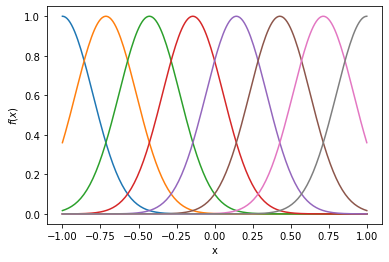

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-1, 1, 200)
X = gaussian_features(x, 8, 0.2)

fig, ax = plt.subplots()

for i in range(X.shape[1]):
    ax.plot(x, X[:, i])
    
ax.set_xlabel('x')
ax.set_ylabel('$\mathit{f(x)}$')
plt.show()

## General Linear Regression
**Determine the best-fit of the peaks below using general linear regression.**

Plot the result of your regression model along with the original data. You can use visual inspection to determine the positions and widths of the peaks.

You may assume that:
- The peaks follow a Gaussian distribution.
- There are 3 peaks of the **same width** in this region of the spectra below.

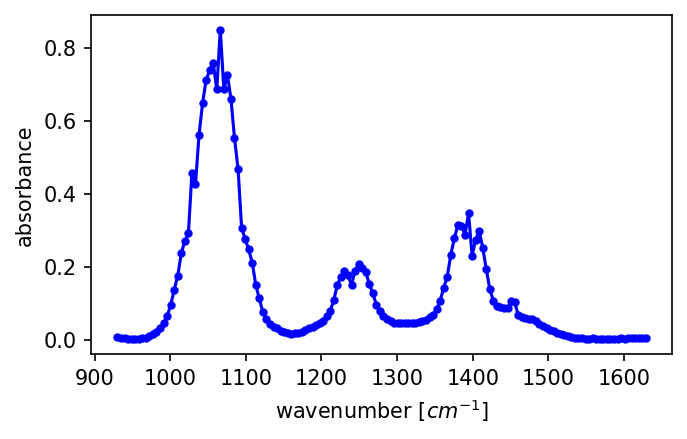

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[100:250]
y_peak = y_all[100:250]

fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x_peak, y_peak, '-b', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

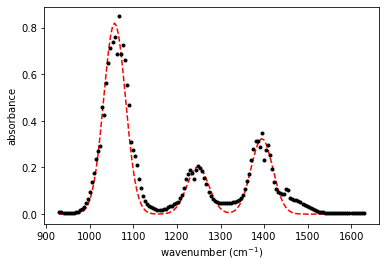

In [4]:
X_gauss = np.zeros((len(x_peak), 3))
X_gauss[:, 0] = np.exp(-(x_peak - 1057)**2 / 2 / 25**2)
X_gauss[:, 1] = np.exp(-(x_peak - 1248)**2 / 2 / 25**2)
X_gauss[:, 2] = np.exp(-(x_peak - 1395)**2 / 2 / 25**2)

A = X_gauss.T@X_gauss
b = X_gauss.T@y_peak

w_lsr = np.linalg.solve(A, b)
yhat = X_gauss@w_lsr

fig, ax = plt.subplots()
ax.plot(x_peak, yhat, '--r')
ax.plot(x_peak, y_peak, '.k')
ax.set_xlabel('wavenumber (cm$^{-1}$)')
ax.set_ylabel('absorbance')
plt.show()

**Briefly describe the result.**

**Continue improving the general linear regression model.**

Now the second assumption is gone. You do not know how many peaks there are, or the widths of the peaks. However, you do know that they follow Gaussian distributions.

- Use your intuition and trial-and-error to find a model that describes the data.
- Plot the result along with the original data.
- This is not a spectroscopy class. There is no "right answer" to this question.

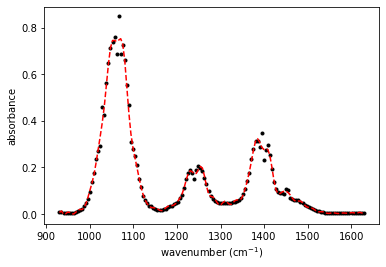

In [5]:
m = 250

X_gauss = gaussian_features(x_peak, m, sigma = 25)

A = X_gauss.T@X_gauss
b = X_gauss.T@y_peak

w_lsr = np.linalg.solve(A, b)
y_hat = X_gauss@w_lsr

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, '.k')
ax.plot(x_peak, y_hat, '--r')
ax.set_xlabel('wavenumber (cm$^{-1}$)')
ax.set_ylabel('absorbance')
plt.show()

## Non-linear Regression

**Write a loss function.**

You want to solve the same problem above using non-linear regression to find the optimal positions and widths of the peaks.

The inputs of the loss function should be:
- a parameter vector $\vec{\lambda} = [ \vec{w}, \vec{\mu}, \vec{\sigma} ]$
- an input vector $x$
- an output vector $y$
- a number of Gaussians $n$

The function should return a root-mean-squared error of the estimation.

In [6]:
def gaussian_loss(lamda, x, y, n):
    y_hat = np.zeros(len(y))
    
    for i in range(m):
        w_i = lamda[i]
        mu_i = lamda[m + i]
        sigma_i = lamda[2 * m + i]
        
        y_hat = y_hat + w_i * np.exp( -(x - mu_i)**2 / 2 / sigma_i**2 )
    
    squared_error = (y - y_hat)**2
    RMSE = np.sqrt(np.sum(squared_error) / len(y))
    return RMSE

**Use `autograd` to compute the derivative of the loss function.**

Find the derivative of the loss function when the parameter vector is [10., 10., 10., 1000., 1250., 1500., 30., 30., 30].

In [7]:
import autograd.numpy as np
from autograd import grad

lamda = np.array([10., 10., 10., 1000., 1250., 1500., 30., 30., 30])
m = 3

def g(lamda, x = x_peak, y = y_peak, m = m):
    return gaussian_loss(lamda, x, y, m)

diff_g = grad(g)

print('Derivative of the loss function: {}'.format(diff_g(lamda)))

Derivative of the loss function: [ 1.57005748e-01  1.58308313e-01  1.60464500e-01 -1.40645451e-03
  8.40456069e-05  2.05938443e-04  2.45406270e-02  2.63444151e-02
  2.65071027e-02]


**Implement gradient descent method.**

Write a function for an iteration of gradient descent that returns the optimal parameters.

The inputs are:
- a parameter vector $\vec{\lambda}$
- a function $g$
- a step size
- a tolerance

In [8]:
# We can use various convergence criterion

# i. root mean square of the displacement between the current and the previous search
def grad_descent(lamda, g, h, tol):
    err = np.inf
    old_lamda = lamda
    
    while err > tol:
        new_lamda = old_lamda - h * g(old_lamda)
        err = np.sqrt(np.mean((new_lamda - old_lamda)**2))
        old_lamda = new_lamda

    return new_lamda

In [9]:
# ii. the norm of the gradient
# I will use this one

def grad_descent(lamda, g, h, tol):
    err = np.inf
    old_lamda = lamda
    
    while err > tol:
        new_lamda = old_lamda - h * g(old_lamda)
        err = np.linalg.norm(g(old_lamda), 2)
        old_lamda = new_lamda
        
    return new_lamda

**Find the optimal parameters.**

Plot the result of non-linear regression along with the original data. Set the number of Gaussians as 5.

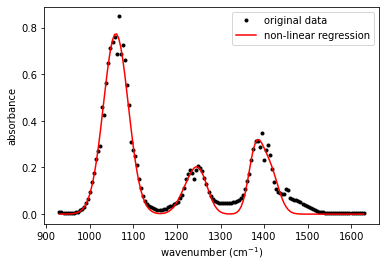

In [10]:
m = 5

guess = np.array([0.6, 0.6, 1.2, .01, 0.1, 1050., 1220., 1250., 1380., 1410., 25., 20., 20., 15., 20.])

f = grad_descent(guess, diff_g, .1, .001)

y_hat = np.zeros(len(y_peak))

for i in range(m):
    w_i = f[i]
    mu_i = f[m + i]
    sigma_i = f[2*m + i]
    
    y_hat += w_i * np.exp( -(x_peak - mu_i)**2 / 2 / sigma_i**2 )
    
fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, '.k', label = 'original data')
ax.plot(x_peak, y_hat, '-r', label = 'non-linear regression')
ax.set_xlabel('wavenumber (cm$^{-1}$)')
ax.set_ylabel('absorbance')
ax.legend()
plt.show()

**Print the weights $\vec{w}$.**

In [11]:
print('Weights: {}'.format(f[:5]))

Weights: [0.77449771 0.07132426 0.17694636 0.23644511 0.20428952]


**Constrain the weights.**

Modify the loss function to constrain the weights to be positive. You can write this in code, or you can write an analytical version of the loss function.

In [12]:
# There are several ways to make constraints

# i. penalize the negative weights (soft constraint)
def gaussian_loss_soft(lamda, x, y, n):
    y_hat = np.zeros(len(y))
    
    for i in range(m):
        w_i = lamda[i]
        mu_i = lamda[m + i]
        sigma_i = lamda[2 * m + i]
        
        y_hat = y_hat + w_i * np.exp( -(x - mu_i)**2 / 2 / sigma_i**2 )
    
    squared_error = (y - y_hat)**2
    soft_const = np.sqrt(np.sum(squared_error) / len(y)) + np.sqrt(np.sum((abs(lamda[:n]) - lamda[:n])**2))
    return soft_const

In [13]:
# ii. force weights to be positive (hard constraint)
def gaussian_loss_hard(lamda, x, y, n):
    y_hat = np.zeros(len(y))
    
    for i in range(m):
        w_i = lamda[i]
        pos_w_i = np.sqrt(w_i**2) # make weights to be positive
        mu_i = lamda[m + i]
        sigma_i = lamda[2*m + i]
        
        y_hat += pos_w_i * np.exp( -(x - mu_i)**2 / 2 / sigma_i**2)
        
    squared_error = (y - y_hat)**2
    hard_const = np.sqrt(np.sum(squared_error) / len(y))
    return hard_const